In [1184]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ast
import category_encoders as ce
from constants import *
from patsy import dmatrices
from statsmodels.compat import lzip
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
%matplotlib inline

In [1149]:
html_folder = 'C:\\Users\\Brayden\\Desktop\\Personal Website\\Brayden-L.github.io\\_includes\\linear_regression_routes\\'

In [1150]:
# Read Data
df = pd.read_pickle('All_Loc_Cleaned_Stripped.pkl')

# Bayes Average for Response Variable

In [1151]:
# Select C for Bayes Average
fig = px.line(x=np.percentile(df['Num Star Ratings'], range(0,100)), y=range(0,100), title='Number of Ratings Percentile Plot', width=800)
fig.update_layout(title_x=0.5)
fig.update_xaxes(title="Number of Ratings")
fig.update_yaxes(title="Percentile (%)")
fig.write_html(html_folder + 'Num_Ratings_Perc.html')
fig

In [1152]:
# Drop values with not enough vote ratings
df.drop(df[df['Num Star Ratings']<5].index, axis=0, inplace=True)

In [1153]:
# Create Bayesian Estimate Rating
m = df['Avg Stars'].mean()
c = df['Num Star Ratings'].quantile(0.25)
df['Bayesian Stars'] = ((df['Avg Stars'] * df['Num Star Ratings']) + (c*m)) / (df['Num Star Ratings'] + c)

In [1154]:
# Compare old rating scale to new
x0 = df['Avg Stars']
x1 = df['Bayesian Stars']
rate_comp_df =pd.DataFrame(dict(
    series=np.concatenate((["Average Stars"]*len(x0), ["Bayesian Stars"]*len(x1))), 
    data  =np.concatenate((x0,x1))
))
fig = px.histogram(rate_comp_df, color='series', barmode='overlay', marginal='box')
fig.update_layout(title='Avg Vs. Bayesian Stars Histogram', title_x=0.5)
fig.update_xaxes(title="Stars", row=1,col=1)
fig.update_yaxes(title="Count")
fig.write_html(html_folder + 'Avg_Vs_Baye_Hist.html')
fig

In [1155]:
# Remove old response variable data
df.drop(['Avg Stars', 'Num Star Ratings'], axis=1, inplace=True)
df.drop(['Base Location'], axis=1, inplace=True)

# Predictor Data Cleaning and Prep

In [1156]:
# Check a sample
order1=['Route ID', 'Route', 'Location', 'Area Latitude', 'Area Longitude', 'Route Type', 'Rating', 'Risk', 'Length', 'Pitches', 'SP/MP', 'Num Ticks', 'Num Tickers', 'Lead Ratio', 'OS Ratio', 'Repeat Sender Ratio', 'Mean Attempts To RP', 'Bayesian Stars']
df[order1].sample(n=5)

Route ID                     Route  \
5676   106058736                   Pahrump   
28103  106883592             Ugly Duckling   
19088  105732884      There and Back Again   
10028  105723829             The Gold Hunk   
24861  105910852  Jeff and the Giant Reach   

                                                Location  Area Latitude  \
5676   Mustang Ranch > North Wonderland Approach > Wo...       34.05190   
28103  A. Swan Slab > E. Yosemite Falls Area > Valley...       37.74499   
19088  Black Orpheus Amphitheater > 12-Oak Creek Cany...       36.10256   
10028  Touch and Go Face > Echo Rock Area > Central J...       34.02559   
24861  Zoe > Murrin Park > Squamish > British Columbi...       49.64450   

       Area Longitude Route Type Rating Risk  Length  Pitches SP/MP  \
5676       -116.18153       Trad    5.4  NaN    40.0        1    SP   
28103      -119.59990       Trad  5.10c    R   200.0        2    MP   
19088      -115.49045       Trad    5.8  NaN   540.0        5    MP   
10028      -116.15740       Trad  5.11b  NaN    70.0        1    SP   
24861      -123.20810      Sport  5.11c  NaN    75.0        1    SP   

       Num Ticks  Num Tickers  Lead Ratio  OS Ratio  Repeat Sender Ratio  \
5676        21.0         20.0    0.444444  1.000000             1.000000   
28103        7.0          7.0    0.800000  1.000000             1.000000   
19088       61.0         51.0    0.900000  1.000000             1.000000   
10028       22.0         21.0    0.300000  0.166667             1.000000   
24861      161.0        139.0    0.776119  0.244898             1.019231   

       Mean Attempts To RP  Bayesian Stars  
5676                   NaN        2.094470  
28103                  NaN        2.450576  
19088                  NaN        2.446923  
10028             1.000000        2.611126  
24861             1.178571        3.409436

In [1157]:
# Route ID
df.set_index('Route ID', inplace=True)

In [1158]:
# Location
df.drop('Location', axis=1, inplace=True)

In [1159]:
# Area Latitude and Longitude
loc_dens = df.groupby(['Area Latitude', 'Area Longitude']).size().reset_index()
loc_dens.rename(columns={0:'Count'}, inplace=True)
loc_dens
fig = px.density_mapbox(loc_dens, lat='Area Latitude', lon='Area Longitude', z='Count', mapbox_style="open-street-map", center={'lat':39.8283, 'lon':-101.299591}, zoom=2.5, width=800)
fig.update_layout(showlegend=False)
fig.write_html(html_folder + 'Loc_Map.html')
fig

In [1160]:
# Route Type
df.drop(df[df['Route Type'] == 'Boulder'].index, inplace=True)
df.drop(df[df['Route Type'].isna()].index, inplace=True)
df['Route Type'].value_counts()

Trad       8592
Sport      7598
Boulder       0
Name: Route Type, dtype: int64

In [1161]:
# Risk
# Replace NA with 'G'
df['Risk'] = df['Risk'].cat.set_categories(['G', 'PG13', 'R', 'X'], ordered=True)
df.loc[df['Risk'].isna(), 'Risk'] = 'G'
# Ordinal Encode
ce_ord = ce.OrdinalEncoder(cols=['Risk'])
df = ce_ord.fit_transform(df)

In [1162]:
df['SP/MP'].value_counts()

SP    14075
MP     2115
Name: SP/MP, dtype: int64

In [1163]:
# Change Trad/Sport column to "Is Trad"
df['Is Trad'] = df['Route Type'].map({"Trad":1, "Sport":0}).astype(int)
df.drop('Route Type', axis=1, inplace=True)
# Change SP/MP solumn to "Is SP"
df['Is SP'] = df['SP/MP'].map({'SP':1, 'MP':0}).astype(int)
df.drop('SP/MP', axis=1, inplace=True)

In [1164]:
# Homogenize Rating
def grade_homo(df_source, r_type, r_direction, b_type, b_direction):
    """
    Reassigns grades to a single YDS or Vgrade schema.

    Parameters
    ----------
    df_source : df
        Original route df.
    r_type : str [letter, sign]
        YDS letter or sign style grades.
    r_direction : str [up, down, even_rand, manual]
        Unused if r_type='letter'. Which way to assign grades. even_rand rounds a randomly selected half up and the randomly remaining half down.
    b_type : str [flat, sign]
        Vgrade flat grades or include sign grades.
    b_direction : str [up, down, even_rand, manual]
        Used for both b_type.

    Return
    ------
    df_source : df
        Original df with grade homogenization
    """
    rating_isolate = df_source["Original Rating"].apply(
        lambda row: [val for val in row.split()][0]
    )  # This is a fail-safe to ensure we are only looking at the part of the rating we care about, not risk or sub-ratings.

    # Reset 'Rating' column so this mapping can be re-run
    df_source["Rating"] = df_source["Original Rating"]

    # Roped Grades
    def grademoderate():
        grade_change_subset = rating_isolate.isin(list(rgrademoderatemap.keys()))
        df_source.loc[grade_change_subset, "Rating"] = df_source.loc[
            grade_change_subset
        ]["Original Rating"].map(rgrademoderatemap)

    def grade_split(upmap, downmap):
        grade_change_subset = rating_isolate.isin(list(upmap.keys()))
        grade_change_subset_df = df_source[grade_change_subset]
        for grade in grade_change_subset_df["Original Rating"].unique():
            to_change = grade_change_subset_df[
                grade_change_subset_df["Original Rating"] == grade
            ]
            changed_up = to_change.sample(frac=0.5)["Original Rating"].map(upmap)
            df_source.loc[changed_up.index, "Rating"] = changed_up
        grade_change_subset = rating_isolate.isin(list(downmap.keys()))
        grade_change_subset_df = df_source[grade_change_subset]
        for grade in grade_change_subset_df["Original Rating"].unique():
            to_change = grade_change_subset_df[
                grade_change_subset_df["Original Rating"] == grade
            ]
            changed_down = to_change["Original Rating"].map(downmap)
            df_source.loc[changed_down.index, "Rating"] = changed_down

    if r_type == "sign":
        grade_change_subset = rating_isolate.isin(list(rgradecompmap.keys()))
        df_source.loc[grade_change_subset, "Rating"] = df_source[grade_change_subset][
            "Original Rating"
        ].map(rgradecompmap)
    else:
        if r_direction == "up":
            grademoderate()
            grade_change_subset = rating_isolate.isin(list(rgradeupmap.keys()))
            df_source.loc[grade_change_subset, "Rating"] = df_source[
                grade_change_subset
            ]["Original Rating"].map(rgradeupmap)
        if r_direction == "down":
            grademoderate()
            grade_change_subset = rating_isolate.isin(list(rgradedownmap.keys()))
            df_source.loc[grade_change_subset, "Rating"] = df_source[
                grade_change_subset
            ]["Original Rating"].map(rgradedownmap)
        if r_direction == "even_rand":
            grademoderate()
            grade_split(rgradeupmap, rgradedownmap)

    # Boulder Grades
    if b_type == "flat":
        # Remove all + and - grades
        grade_change_subset = rating_isolate.isin(list(bgradeconmapflat.keys()))
        df_source.loc[grade_change_subset, "Rating"] = df_source[grade_change_subset][
            "Original Rating"
        ].map(bgradeconmapflat)

        if b_direction == "up":
            grade_change_subset = rating_isolate.isin(list(bgradeupmapflat.keys()))
            df_source.loc[grade_change_subset, "Rating"] = df_source[
                grade_change_subset
            ]["Original Rating"].map(bgradeupmapflat)
        if b_direction == "down":
            grade_change_subset = rating_isolate.isin(list(bgradedownmapflat.keys()))
            df_source.loc[grade_change_subset, "Rating"] = df_source[
                grade_change_subset
            ]["Original Rating"].map(bgradedownmapflat)
        if b_direction == "even_rand":
            grade_split(bgradeupmapflat, bgradedownmapflat)

    if b_type == "sign":
        if b_direction == "up":
            grade_change_subset = rating_isolate.isin(list(bgradeupmapsign.keys()))
            df_source.loc[grade_change_subset, "Rating"] = df_source[
                grade_change_subset
            ]["Original Rating"].map(bgradeupmapsign)
        if b_direction == "down":
            grade_change_subset = rating_isolate.isin(list(bgradedownmapsign.keys()))
            df_source.loc[grade_change_subset, "Rating"] = df_source[
                grade_change_subset
            ]["Original Rating"].map(bgradedownmapsign)
        if b_direction == "even_rand":
            grade_split(bgradeupmapsign, bgradedownmapsign)

    return df_source

df['Original Rating'] = df['Rating']
df = grade_homo(df, 'letter', 'even_rand', 'flat', 'down')
df.drop('Original Rating', axis=1, inplace=True)

In [1165]:
# Remove null rating values which are likely 3rd, 4th class etc. Not relevant.
df.drop(df[df['Rating'].isna()].index, inplace=True)

# Encode Rating
df['Rating'].cat.set_categories(YDS_GRADES_LETTER, ordered=True, inplace=True)
fig = px.histogram(df['Rating'], category_orders={'Rating': YDS_GRADES_LETTER})
fig.update_xaxes(type="category", categoryorder='array', categoryarray=YDS_GRADES_LETTER, title='Grade')
fig.update_layout(showlegend=False, title='Rating Histogram', title_x=0.5, width=800)
fig.write_html(html_folder + 'Rating_Hist.html')
fig

C:\Users\Brayden\AppData\Local\Temp\ipykernel_13340\2263869135.py:5: FutureWarning:

The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.



In [1166]:
ce_ord = ce.OrdinalEncoder(cols=['Rating'])
df = ce_ord.fit_transform(df)

In [1167]:
# Pitches
fig = px.histogram(df[df['Pitches']>1]['Pitches'], marginal='box')
fig.update_xaxes(title='Number of Pitches', row=1,col=1)
fig.update_layout(showlegend=False, title='Pitches Histogram', title_x=0.5, width=800)
fig.write_html(html_folder + 'Pitches_Hist.html')
fig

In [1168]:
# Num Ticks
df.loc[df['Num Ticks'].isna(), 'Num Ticks'] = int(0)

fig = px.histogram(df['Num Ticks'], marginal='box')
fig.update_xaxes(title='Number of Ticks', row=1,col=1)
fig.update_layout(showlegend=False, title='Number of Ticks Histogram', title_x=0.5, width=800)
fig.write_html(html_folder + 'NumTicks_Hist.html')
fig

In [1169]:
df.shape[0]

df[df['OS Ratio'].isna()].shape[0]
df[df['Repeat Sender Ratio'].isna()].shape[0]
df[df['Mean Attempts To RP'].isna()].shape[0]

5362

In [1170]:
# Lead Ratio
print(df[df['Lead Ratio'].isna()].shape[0])

# Impute
print(df['Lead Ratio'].median())
df.loc[df['Lead Ratio'].isna(), 'Lead Ratio'] = df['Lead Ratio'].median()

# Create Bayesian Estimate Rating
m = df['Lead Ratio'].mean()
c = 30
df['Lead Ratio Baye'] = ((df['Lead Ratio'] * df['Num Ticks']) + (c*m)) / (df['Num Ticks'] + c)

#Compare
x0 = df['Lead Ratio']
x1 = df['Lead Ratio Baye']
rate_comp_df =pd.DataFrame(dict(
    series=np.concatenate((["Lead Ratio"]*len(x0), ["Bayesian Avg Lead Ratio"]*len(x1))), 
    data  =np.concatenate((x0,x1))
))
fig1 = px.histogram(rate_comp_df, color='series', barmode='overlay', marginal='box')
fig1.update_layout(title='Lead Ratio Bayesian Avg Comparison Histogram', title_x=0.5)
fig1.update_xaxes(title="Lead Ratio", row=1,col=1)
fig1.update_yaxes(title="Count")
fig1.write_html(html_folder + 'LeadRatio_Bayecomp_Hist.html')
fig1

fig2 = px.histogram(df['Lead Ratio'], marginal='box')
fig2.update_xaxes(title='Lead Ratio', row=1,col=1)
fig2.update_layout(showlegend=False, title='Lead Ratio Histogram', title_x=0.5, width=800)
fig2.write_html(html_folder + 'LeadRatio_Hist.html')
fig2

129
0.7354497354497355


In [1171]:
# OS Ratio
print(df[df['OS Ratio'].isna()].shape[0])

# Impute
print(df['OS Ratio'].median())
df.loc[df['OS Ratio'].isna(), 'OS Ratio'] = df['OS Ratio'].median()

# Create Bayesian Estimate Rating
m = df['OS Ratio'].mean()
c = 30
df['OS Ratio Baye'] = ((df['OS Ratio'] * df['Num Ticks']) + (c*m)) / (df['Num Ticks'] + c)

#Compare
x0 = df['OS Ratio']
x1 = df['OS Ratio Baye']
rate_comp_df =pd.DataFrame(dict(
    series=np.concatenate((["OS Ratio"]*len(x0), ["Bayesian Avg OS Ratio"]*len(x1))), 
    data  =np.concatenate((x0,x1))
))
fig1 = px.histogram(rate_comp_df, color='series', barmode='overlay', marginal='box')
fig1.update_layout(title='OS Ratio Bayesian Avg Comparison Histogram', title_x=0.5)
fig1.update_xaxes(title="OS Ratio", row=1,col=1)
fig1.update_yaxes(title="Count")
fig1.write_html(html_folder + 'OSRatio_Bayecomp_Hist.html')
fig1

fig2 = px.histogram(df['OS Ratio'], marginal='box')
fig2.update_xaxes(title='OS Ratio', row=1,col=1)
fig2.update_layout(showlegend=False, title='OS Ratio Histogram', title_x=0.5, width=800)
fig2.write_html(html_folder + 'OSRatio_Hist.html')
fig2

601
0.6933333333333334


In [1172]:
# Repeat Sender Ratio
print(df[df['Repeat Sender Ratio'].isna()].shape[0])

# Impute
print(df['Repeat Sender Ratio'].median())
df.loc[df['Repeat Sender Ratio'].isna(), 'Repeat Sender Ratio'] = 1

# Create Bayesian Estimate Rating
m = df['Repeat Sender Ratio'].mean()
c = 30
df['Repeat Sender Ratio Baye'] = ((df['Repeat Sender Ratio'] * df['Num Ticks']) + (c*m)) / (df['Num Ticks'] + c)

#Compare
x0 = df['Repeat Sender Ratio']
x1 = df['Repeat Sender Ratio Baye']
rate_comp_df =pd.DataFrame(dict(
    series=np.concatenate((["Repeat Sender Ratio"]*len(x0), ["Bayesian Avg Repeat Sender Ratio"]*len(x1))), 
    data  =np.concatenate((x0,x1))
))
fig1 = px.histogram(rate_comp_df, color='series', barmode='overlay', marginal='box')
fig1.update_layout(title='Repeat Sender Ratio Bayesian Avg Comparison Histogram', title_x=0.5)
fig1.update_xaxes(title="Repeat Sender Ratio", row=1,col=1)
fig1.update_yaxes(title="Count")
fig1.write_html(html_folder + 'RepeatSender_Bayecomp_Hist.html')
fig1

fig2 = px.histogram(df['Repeat Sender Ratio'], marginal='box')
fig2.update_xaxes(title='Repeat Sender Ratio', row=1,col=1)
fig2.update_layout(showlegend=False, title='Repeat Sender Ratio Histogram', title_x=0.5, width=800)
fig2.write_html(html_folder + 'RepeatSender_Hist.html')
fig2

fig3 = px.histogram(df.loc[df['Repeat Sender Ratio']>1, 'Repeat Sender Ratio'], marginal='box')
fig3.update_xaxes(title='Repeat Sender Ratio', range=[1,3], row=1,col=1)
fig3.update_layout(showlegend=False, title='Repeat Sender Ratio Histogram (Val=1 Omitted)', title_x=0.5, width=800)
fig3.write_html(html_folder + 'RepeatSender_1omit_Hist.html')
fig3

875
1.0


In [1173]:
# Mean Attempts To RP
print(df[df['Mean Attempts To RP'].isna()].shape[0])

# Impute
print(df['Mean Attempts To RP'].median())
df.loc[df['Mean Attempts To RP'].isna(), 'Mean Attempts To RP'] = 1

# Create Bayesian Estimate Rating
m = df['Mean Attempts To RP'].mean()
c = 30
df['Mean Attempts To RP Baye'] = ((df['Mean Attempts To RP'] * df['Num Ticks']) + (c*m)) / (df['Num Ticks'] + c)

#Compare
x0 = df['Mean Attempts To RP']
x1 = df['Mean Attempts To RP Baye']
rate_comp_df =pd.DataFrame(dict(
    series=np.concatenate((["Mean Attempts To RP"]*len(x0), ["Bayesian Avg Mean Attempts To RP"]*len(x1))), 
    data  =np.concatenate((x0,x1))
))
fig1 = px.histogram(rate_comp_df, color='series', barmode='overlay', marginal='box')
fig1.update_layout(title='Mean Attempts To RP Bayesian Avg Comparison Histogram', title_x=0.5)
fig1.update_xaxes(title="Mean Attempts To RP", row=1,col=1)
fig1.update_yaxes(title="Count")
fig1.write_html(html_folder + 'MeanAttemptsToRP_Bayecomp_Hist.html')
fig1

fig2 = px.histogram(df['Mean Attempts To RP'], marginal='box')
fig2.update_xaxes(title='Mean Attempts To RP', row=1,col=1)
fig2.update_layout(showlegend=False, title='Mean Attempts To RP Histogram', title_x=0.5, width=800)
fig2.write_html(html_folder + 'MeanAttemptsToRP_Hist.html')
fig2

fig3 = px.histogram(df.loc[df['Mean Attempts To RP']>1, 'Mean Attempts To RP'], marginal='box')
fig3.update_xaxes(title='Mean Attempts To RP', range=[1,5], row=1,col=1)
fig3.update_layout(showlegend=False, title='Mean Attempts To RP Histogram (Detail)', title_x=0.5, width=800)
fig3.write_html(html_folder + 'MeanAttemptsToRP_1omit_Hist.html')
fig3

5362
1.1666666666666667


# Check Correlation

In [1174]:
# Drop unwanted columns
df.drop(['Route', 'Lead Ratio Baye', 'OS Ratio Baye', 'Repeat Sender Ratio Baye', 'Mean Attempts To RP Baye'], axis=1, inplace=True)
# df.drop(['Route', 'Lead Ratio', 'OS Ratio', 'Repeat Sender Ratio', 'Mean Attempts To RP'], axis=1, inplace=True)

# Amend column named to _ for Patsy compatibility
df.rename(columns = dict(zip(df.columns,df.columns.str.replace(' ', '_'))), inplace=True)

C:\Users\Brayden\AppData\Local\Temp\ipykernel_13340\1879578168.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



[Text(0.5, 1.0, 'Predictor Correlation Heatmap')]

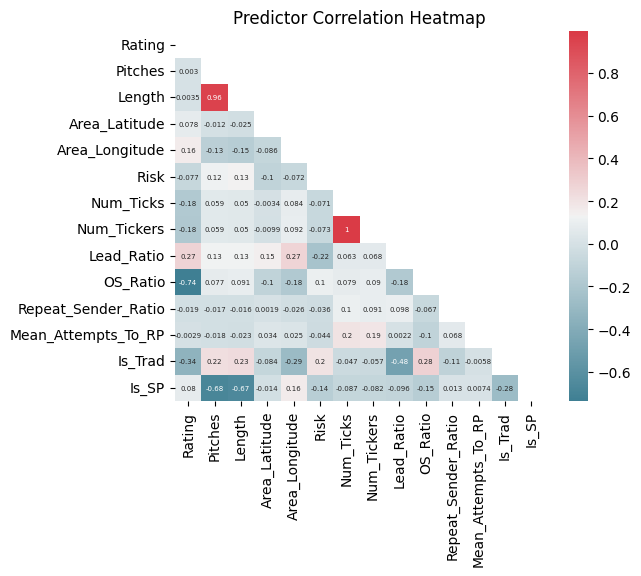

In [1175]:
### Correlation Heatmap
# Calculate correlation using the default method ( "pearson")
corr = df.drop('Bayesian_Stars', axis=1).corr()
# optimize aesthetics: generate mask for removing duplicate / unnecessary info
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap as indicator for correlations:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Plot
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,  square=True, annot_kws={"size": 5}).set(title='Predictor Correlation Heatmap')

In [1176]:
# Rename columns to underscores for patsy compatibility
y_form = 'Bayesian_Stars'
x_form = " + ".join([x for x in df.columns if x != y_form])
formula = f'{y_form} ~ {x_form}'
y, X = dmatrices(formula, df, return_type='dataframe')
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns
vif.round(2).sort_values('VIF Factor')

VIF Factor                 Feature
1         1.06  Length_Missing[T.True]
12        1.07     Repeat_Sender_Ratio
13        1.07     Mean_Attempts_To_RP
5         1.11           Area_Latitude
7         1.11                    Risk
6         1.22          Area_Longitude
10        1.60              Lead_Ratio
14        1.69                 Is_Trad
15        2.05                   Is_SP
11        2.39                OS_Ratio
2         2.56                  Rating
4        11.82                  Length
3        12.10                 Pitches
8       107.93               Num_Ticks
9       108.01             Num_Tickers
0       349.37               Intercept

In [1177]:
df.drop(['Num_Tickers', 'Pitches'], axis=1, inplace=True)

C:\Users\Brayden\AppData\Local\Temp\ipykernel_13340\2615643709.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



[Text(0.5, 1.0, 'Predictor Correlation Heatmap Amended')]

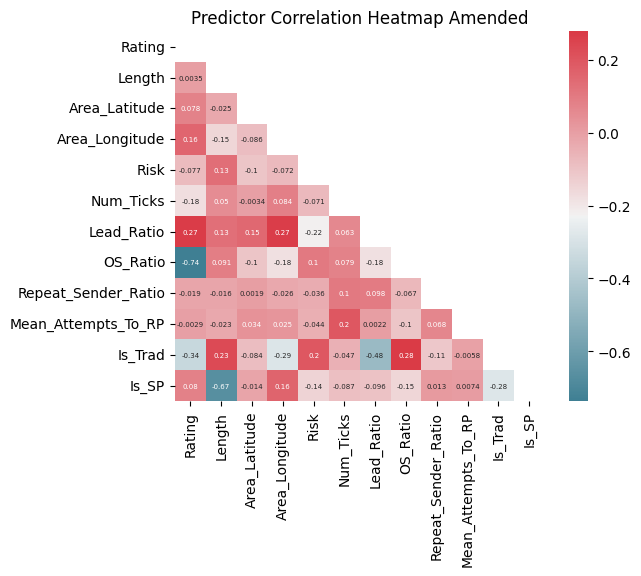

In [1178]:
### Correlation Heatmap
# Calculate correlation using the default method ( "pearson")
corr = df.drop('Bayesian_Stars', axis=1).corr()
# optimize aesthetics: generate mask for removing duplicate / unnecessary info
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap as indicator for correlations:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Plot
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,  square=True, annot_kws={"size": 5}).set(title='Predictor Correlation Heatmap Amended')

In [1179]:
# Rename columns to underscores for patsy compatibility
df.rename(columns = dict(zip(df.columns,df.columns.str.replace(' ', '_'))), inplace=True)
y_form = 'Bayesian_Stars'
x_form = " + ".join([x for x in df.columns if x not in y_form])
formula = f'{y_form} ~ {x_form}'
y, X = dmatrices(formula, df, return_type='dataframe')
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns
vif.round(2).sort_values('VIF Factor')

VIF Factor                 Feature
10        1.05     Repeat_Sender_Ratio
1         1.06  Length_Missing[T.True]
11        1.07     Mean_Attempts_To_RP
4         1.11           Area_Latitude
6         1.11                    Risk
7         1.13               Num_Ticks
5         1.21          Area_Longitude
8         1.60              Lead_Ratio
12        1.67                 Is_Trad
3         1.89                  Length
13        1.94                   Is_SP
9         2.37                OS_Ratio
2         2.54                  Rating
0       334.48               Intercept

In [ ]:
# sns.pairplot(df[['Rating', 'Length', 'Num_Ticks', 'Lead_Ratio', 'OS_Ratio', 'Repeat_Sender_Ratio', 'Mean_Attempts_To_RP']])

# Initial Linear Fit

In [ ]:
# SP only removals
outlier_rem = [105881156,
 109077834,
 109078007,
 106733451,
 105763533,
 105749743,
 105753442,
 105820584,
 105761505,
 105822133,
 105748918,
 105760281,
 105754648,
 105717346,
 105717349,
 105717328,
 105812468,
 105717445,
 118892958,
 106394491,
 106320353,
 105723241,
 105721771,
 105721930,
 105721969,
 105721615,
 105721609,
 105722179,
 105722344,
 105859282,
 105722572,
 107904426,
 105717463,
 106434517,
 106970898,
 105717583,
 106385760,
 107129358,
 105944188,
 106130307,
 106085035,
 106286280,
 107116591,
 107537571,
 108524421,
 106085043,
 106061906,
 106065471,
 106125099,
 108150461,
 105880926,
 106586504,
 106125070,
 105732302,
 105813275,
 105903232,
 105856887,
 105849844,
 105732962,
 105819734,
 105942236,
 105942224,
 105732554,
 106738092,
 105811838,
 106757203,
 105886249,
 105944541,
 105944650,
 105732557,
 105732560,
 105732563,
 105732566,
 105732515,
 105826083,
 105732512,
 105733016,
 105878180,
 105966659,
 111849930,
 106057495,
 105789060,
 105820726,
 105789064,
 107118805,
 105892174,
 106510756,
 113862808,
 108207471,
 106811001,
 105872317]

In [ ]:
# Both SP and MP Outliers
outlier_rem = [117081171,
 105885929,
 105881156,
 105911150,
 105956126,
 111310496,
 111185612,
 105908028,
 118587175,
 118202084,
 117081133,
 107750488,
 106757578,
 105845614,
 105911137,
 118620808,
 105907235,
 105911123,
 118338680,
 105922646,
 105896599,
 118592305,
 106728123,
 105750412,
 105760119,
 106439093,
 105756778,
 107140288,
 105763155,
 105764976,
 105752869,
 114323402,
 109077961,
 105752002,
 105763587,
 109642087,
 111172847,
 105761190,
 107222256,
 106767107,
 105755134,
 105753697,
 105761235,
 107802118,
 109607020,
 105763533,
 105755191,
 105750568,
 105749869,
 105750472,
 105748391,
 105760905,
 105748361,
 105751342,
 105764211,
 105760239,
 105748490,
 105748612,
 105749743,
 105749737,
 105754918,
 105748642,
 105757279,
 105759822,
 105753511,
 105753442,
 105762483,
 105762369,
 105761505,
 105750106,
 105752884,
 105752518,
 105752656,
 106066032,
 105748918,
 105753055,
 105760281,
 105761310,
 105754648,
 105749242,
 105756397,
 105999845,
 106145091,
 105761439,
 105755281,
 105988139,
 105752266,
 106499440,
 108221614,
 105792077,
 105802684,
 105802833,
 106169851,
 107224919,
 105811901,
 106754645,
 106170636,
 106736873,
 106790885,
 105809048,
 109227746,
 105803532,
 110776954,
 109475790,
 105790657,
 106328525,
 105805752,
 115340959,
 122758754,
 106477409,
 122603709,
 105805970,
 105717349,
 105812468,
 105717598,
 105717445,
 106574480,
 116685757,
 105717979,
 116707845,
 118892958,
 105724393,
 105721771,
 105722224,
 105797044,
 105797048,
 105725725,
 105721615,
 105721609,
 105839905,
 105723775,
 105725704,
 105722479,
 106084748,
 105816299,
 106239395,
 105722509,
 105721624,
 105722587,
 105721816,
 105725074,
 105723433,
 105722344,
 106325623,
 105721894,
 105725551,
 105722572,
 105723994,
 105723073,
 106061102,
 107099451,
 105723961,
 105725803,
 106345203,
 105812282,
 105735227,
 105858248,
 105736220,
 108458326,
 122548167,
 122873952,
 105898533,
 107706079,
 105877553,
 105912058,
 107762767,
 107762760,
 105912164,
 105717622,
 105717556,
 106369896,
 106434517,
 106564662,
 107619348,
 105717583,
 114375298,
 107892801,
 106385760,
 106039953,
 106039070,
 107129358,
 105949134,
 105944188,
 105963496,
 105943666,
 109175873,
 113785114,
 108443815,
 106064690,
 105961494,
 106130307,
 106085035,
 106286280,
 107116591,
 107537571,
 108524421,
 106085043,
 107855115,
 106973561,
 106125099,
 114509822,
 105868000,
 105854070,
 105880881,
 105885179,
 105870026,
 105854135,
 105882024,
 106730200,
 107775577,
 106405603,
 106730391,
 105860741,
 105880926,
 106125070,
 107051854,
 114115512,
 105813275,
 105732638,
 106757206,
 105733115,
 105732419,
 109607912,
 105791012,
 105849844,
 105732365,
 105732266,
 105733043,
 105732962,
 105819734,
 105946440,
 105732554,
 105732782,
 105883684,
 105811838,
 106757203,
 105887571,
 106038397,
 105890259,
 105732440,
 105732866,
 105732425,
 105732836,
 105886249,
 108021393,
 107339211,
 105944541,
 105944650,
 105733037,
 105732557,
 105732560,
 105732563,
 105732566,
 105732515,
 105826083,
 105733016,
 105732344,
 106585757,
 107455347,
 116206143,
 107026943,
 106387625,
 118309782,
 105808866,
 106500890,
 105754429,
 105754096,
 106440532,
 106015569,
 105749968,
 105754009,
 110991434,
 105910536,
 105884987,
 106159755,
 106088344,
 105945876,
 105925169,
 105986139,
 105939289,
 105922314,
 105878180,
 105906913,
 105968581,
 106043129,
 107167477,
 105998986,
 105966659,
 106009347,
 105971474,
 106009341,
 106975578,
 107097013,
 106837931,
 106057598,
 106784670,
 106119554,
 105923973,
 106352109,
 106009353,
 105984278,
 105966743,
 105966728,
 105966733,
 106159743,
 105931493,
 106913131,
 111849930,
 105956667,
 106041026,
 113505828,
 106441367,
 106721130,
 107728069,
 110964463,
 105789060,
 105820726,
 105789064,
 105790438,
 106193107,
 106154363,
 106811013,
 105804599,
 107118805,
 107124539,
 121871272,
 108418721,
 109054041,
 105892174,
 107253323,
 105806955,
 107272249,
 106621058,
 106708088,
 111748530,
 117688359,
 105947052,
 111849325,
 110716062,
 121118772,
 109397495,
 107311945,
 105834294,
 105834273,
 105834215,
 105834244,
 105844453,
 106509913,
 106479549,
 105861268,
 108299553,
 111312245,
 105862957,
 105862991,
 113862808,
 105835705,
 108207471,
 105879729,
 106167844,
 119131000,
 105751207,
 105752155,
 105755356,
 105752185,
 105895689,
 105763644,
 109253292,
 106023905,
 106685529,
 105836362,
 105862873,
 106026270,
 105915955,
 105848567,
 105862896,
 117698246,
 113069305,
 105862890,
 105889783,
 105988273,
 105867008,
 105916892,
 105862639,
 105833505,
 107160287,
 106683463,
 109275454,
 120010260,
 106261545,
 112356641,
 109951912,
 116716417,
 106972226,
 105717883,
 106074786,
 120552911,
 106655018,
 106569989,
 111004634,
 106673057]

In [ ]:
# df.drop(outlier_rem, axis=0, inplace=True)

In [1201]:
df.drop(df[df['Mean_Attempts_To_RP']>4].index, axis=0, inplace=True)
df.drop(df[df['Repeat_Sender_Ratio']>2].index, axis=0, inplace=True)

In [ ]:
# SP only analysis
# df.drop(df[df['Is_SP']==0].index, axis=0, inplace=True)

In [ ]:
interaction_terms = 'Repeat_Sender_Ratio*Is_Trad + Num_Ticks*OS_Ratio + Area_Longitude*Is_SP + Length_Missing*Num_Ticks + Is_Trad*Is_SP + Length_Missing*Area_Longitude + Area_Longitude*Risk + OS_Ratio*Repeat_Sender_Ratio + Lead_Ratio*Mean_Attempts_To_RP + Mean_Attempts_To_RP*Is_Trad + Area_Latitude*Is_SP + Num_Ticks*Lead_Ratio + Rating*Num_Ticks + Rating*Mean_Attempts_To_RP + Rating*Is_Trad + Length*Is_Trad + Length*Is_SP + Area_Latitude*Area_Longitude + Area_Latitude*Num_Ticks + Area_Latitude*Is_Trad + Area_Longitude*Num_Ticks + Area_Longitude*Is_Trad + Risk*Is_SP + Num_Ticks*Repeat_Sender_Ratio + Num_Ticks*Is_Trad + Lead_Ratio*Is_Trad'

In [1202]:
y_form = 'Bayesian_Stars'
x_form = " + ".join([x for x in df.columns if not x in [y_form, 'Is_SP', 'Area_Latitude', 'Area_Longitude']])
formula = f'{y_form} ~ {x_form}'
# formula = f'{y_form} ~ Rating + Num_Ticks + Length + Is_Trad + Risk'

lm = smf.ols(formula, data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Bayesian_Stars   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     1200.
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:15:15   Log-Likelihood:                -6316.6
No. Observations:               16079   AIC:                         1.266e+04
Df Residuals:                   16068   BIC:                         1.274e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.0417      0.048     21.733      0.000       0.948       1.136
Length_Missing[T.True]    -0.0295      0.009     -3.305      0.001      -0.047      -0.012
Rating                     0.0659      0.001     64.469      0.000       0.064       0.068
Length                     0.0004   1.62e-05     21.815      0.000       0.000       0.000
Risk                      -0.0189      0.007     -2.899      0.004      -0.032      -0.006
Num_Ticks                  0.0004   9.79e-06     37.519      0.000       0.000       0.000
Lead_Ratio                 0.1812      0.015     12.334      0.000       0.152       0.210
OS_Ratio                   0.0047      0.014      0.334      0.739      -0.023       0.032
Repeat_Sender_Ratio        0.2607      0.037      6.994      0.000       0.188       0.334
Mean_Attempts_To_RP        0.1653      0.009     18.754      0.000       0.148       0.183
Is_Trad                    0.2072      0.007     28.956      0.000       0.193       0.221
==============================================================================
Omnibus:                       18.624   Durbin-Watson:                   1.559
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.153
Skew:                           0.067   Prob(JB):                     6.93e-05
Kurtosis:                       3.103   Cond. No.                     7.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1088]:
lm.summary2(float_format='%.6E')

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.471    
Dependent Variable: Bayesian_Stars   AIC:                9313.1280
Date:               2023-03-15 10:37 BIC:                9358.3869
No. Observations:   13949            Log-Likelihood:     -4650.6  
Df Model:           5                F-statistic:        2484.    
Df Residuals:       13943            Prob (F-statistic): 0.00     
R-squared:          0.471            Scale:              0.11410  
-------------------------------------------------------------------
               Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept      1.4290    0.0149   95.5898  0.0000   1.3997   1.4583
Rating         0.0649    0.0007   91.1846  0.0000   0.0635   0.0663
Num_Ticks      0.0005    0.0000   42.0609  0.0000   0.0005   0.0006
Length         0.0045    0.0001   41.1674  0.0000   0.0043   0.0047
Is_Trad        0.1339    0.0064   20.9399  0.0000   0.1214   0.1464
Risk          -0.0804    0.0074  -10.9249  0.0000  -0.0948  -0.0659
------------------------------------------------------------------
Omnibus:               20.698       Durbin-Watson:          1.579 
Prob(Omnibus):         0.000        Jarque-Bera (JB):       20.758
Skew:                  0.091        Prob(JB):               0.000 
Kurtosis:              3.053        Condition No.:          1465  
==================================================================
* The condition number is large (1e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

In [1089]:
print(np.sqrt(lm.mse_resid))
np.sqrt(lm.mse_resid)/df['Bayesian_Stars'].mean()

0.33779173024716896


0.12809208489970295

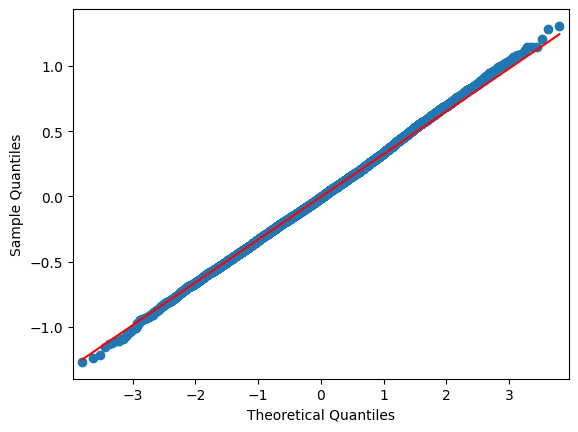

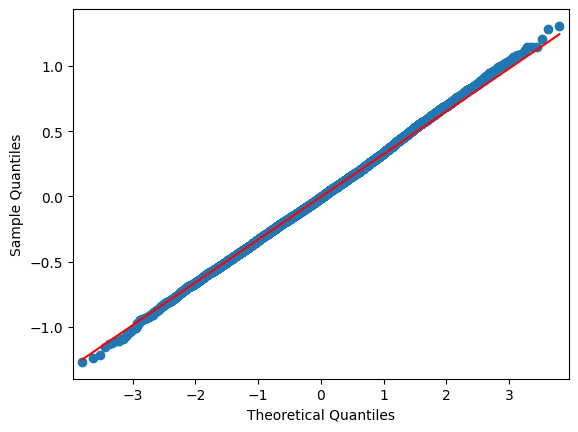

In [1090]:
# Error Normality
sm.qqplot(lm.resid, line='q')

Text(0, 0.5, 'Residuals')

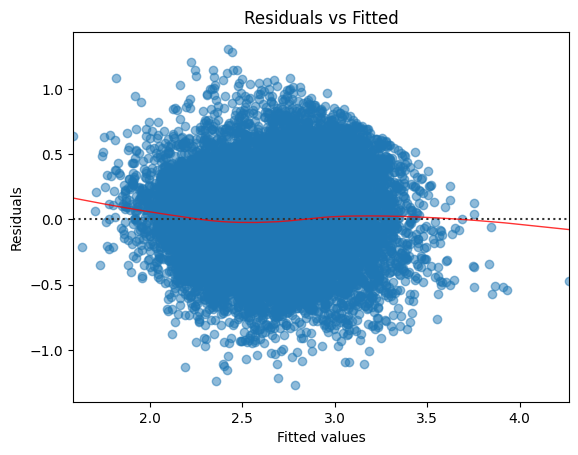

In [1091]:
# Residual vs Fitted Values Plot

plot = sns.residplot(x=lm.fittedvalues, y='Bayesian_Stars', data=df, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

# Title and labels
plot.set_title('Residuals vs Fitted')
plot.set_xlabel('Fitted values')
plot.set_ylabel('Residuals')

In [1092]:
# B-P Lagrange Multiplier Test
bp_name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_test = sm.stats.het_breuschpagan(lm.resid, lm.model.exog)
lzip(bp_name, bp_test)

[('Lagrange multiplier statistic', 291.66740140291034),
 ('p-value', 6.192107162220194e-61),
 ('f-value', 59.55362876903979),
 ('f p-value', 1.4047088788884352e-61)]

Critical Cooks distance: 0.00021662446598704643
Int64Index([116739846, 105900244, 118665298, 118172006, 118154572, 106446253,
            105843581, 105885929, 105972941, 120013429,
            ...
            105874590, 105872888, 105936538, 106026258, 108379100, 113886286,
            105717895, 107312510, 105717892, 107476507],
           dtype='int64', name='Route ID', length=1102) 
 [0.00022173 0.00022234 0.00041241 ... 0.00025659 0.00021942 0.0003002 ]


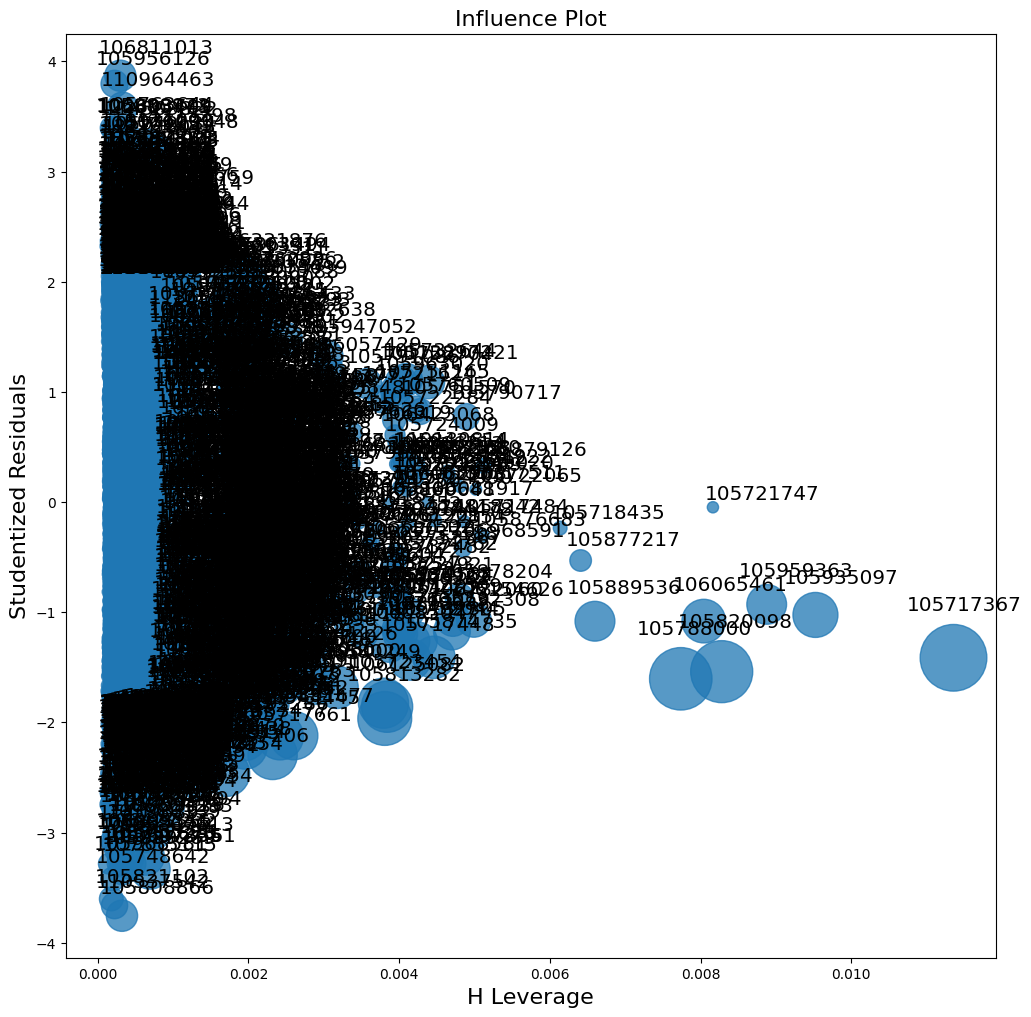

In [1093]:
# Leverage vs. Normalized Residuals
# Plot Cooks Distance
fig, ax = plt.subplots(figsize=(12,12))
fig = sm.graphics.influence_plot(lm, ax=ax)

# obtain Cook's distance 
lm_cooksd = lm.get_influence().cooks_distance[0]

# get length of df to obtain n
n = df.shape[0]

# calculate critical d
critical_d = 3*lm_cooksd.mean()
print('Critical Cooks distance:', critical_d)

# identification of potential outliers with leverage
out_d = lm_cooksd > critical_d

# output potential outliers with leverage
print(df.index[out_d], "\n", 
    lm_cooksd[out_d])

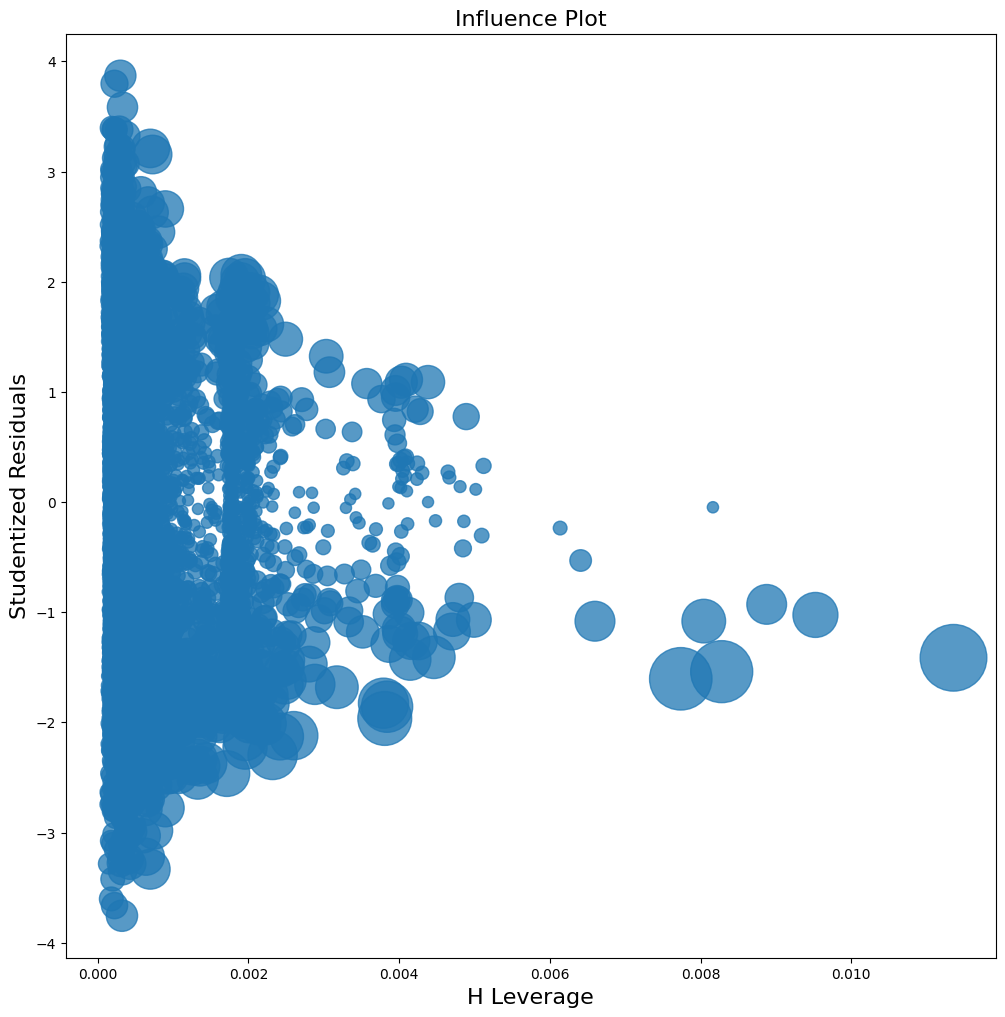

In [1094]:
for child in ax.get_children():
    if isinstance(child, matplotlib.text.Annotation):
        child.remove()
fig

In [1095]:
critical_d = 14*lm_cooksd.mean()
print('Critical Cooks distance:', critical_d)

# identification of potential outliers with leverage
out_d = lm_cooksd > critical_d

# output potential outliers with leverage
df.index[out_d].to_list()

Critical Cooks distance: 0.0010109141746062165


[105848107,
 105752044,
 105760263,
 105753511,
 105752656,
 105749242,
 105753598,
 105805752,
 105717661,
 105867613,
 105821587,
 105717367,
 106331876,
 105900788,
 105724978,
 105859301,
 105723454,
 105722965,
 105874099,
 105889276,
 108007759,
 113206411,
 105717448,
 107619348,
 114375298,
 105961494,
 106085047,
 107596000,
 106580249,
 106973554,
 106973561,
 107353477,
 106065295,
 106876099,
 107807554,
 105891677,
 105889536,
 106730391,
 106065461,
 106081926,
 106125082,
 106286394,
 105732305,
 105813282,
 106337085,
 106337101,
 106757206,
 105826075,
 105732308,
 105732836,
 106755212,
 105732344,
 105800839,
 105944445,
 105820098,
 105788000,
 105922314,
 105923651,
 106159743,
 105959363,
 105935097,
 105789070,
 105790438,
 106277152,
 106191286,
 105860654,
 105866996,
 105874694,
 105841126,
 105874735]

In [1098]:
df.columns

Index(['Rating', 'Length', 'Length_Missing', 'Area_Latitude', 'Area_Longitude',
       'Risk', 'Num_Ticks', 'Lead_Ratio', 'OS_Ratio', 'Repeat_Sender_Ratio',
       'Mean_Attempts_To_RP', 'Bayesian_Stars', 'Is_Trad', 'Is_SP'],
      dtype='object')

eval_env: 1


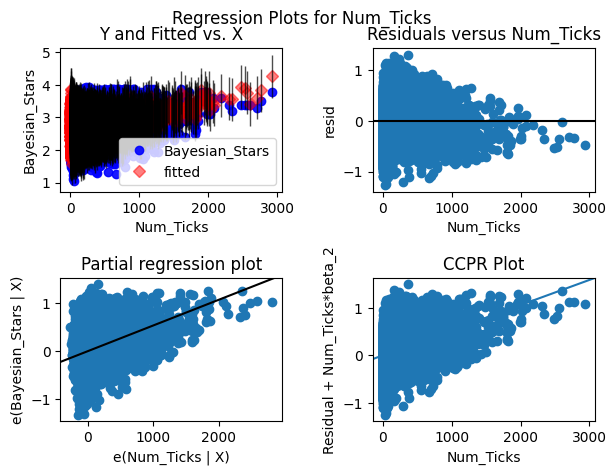

In [1104]:
fig = sm.graphics.plot_regress_exog(lm, "Num_Ticks")

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


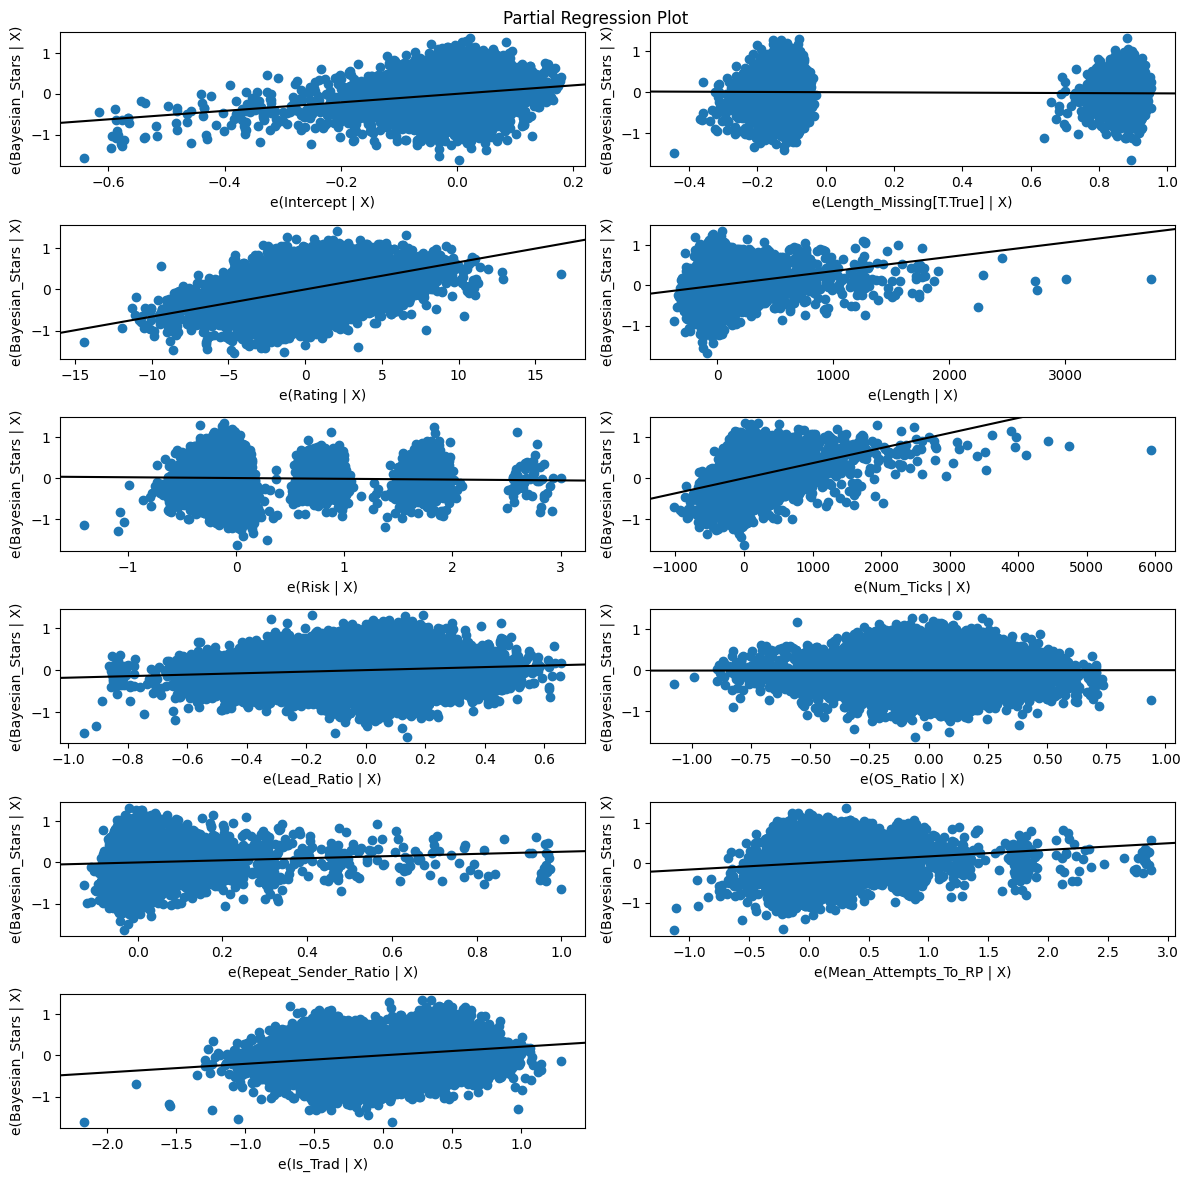

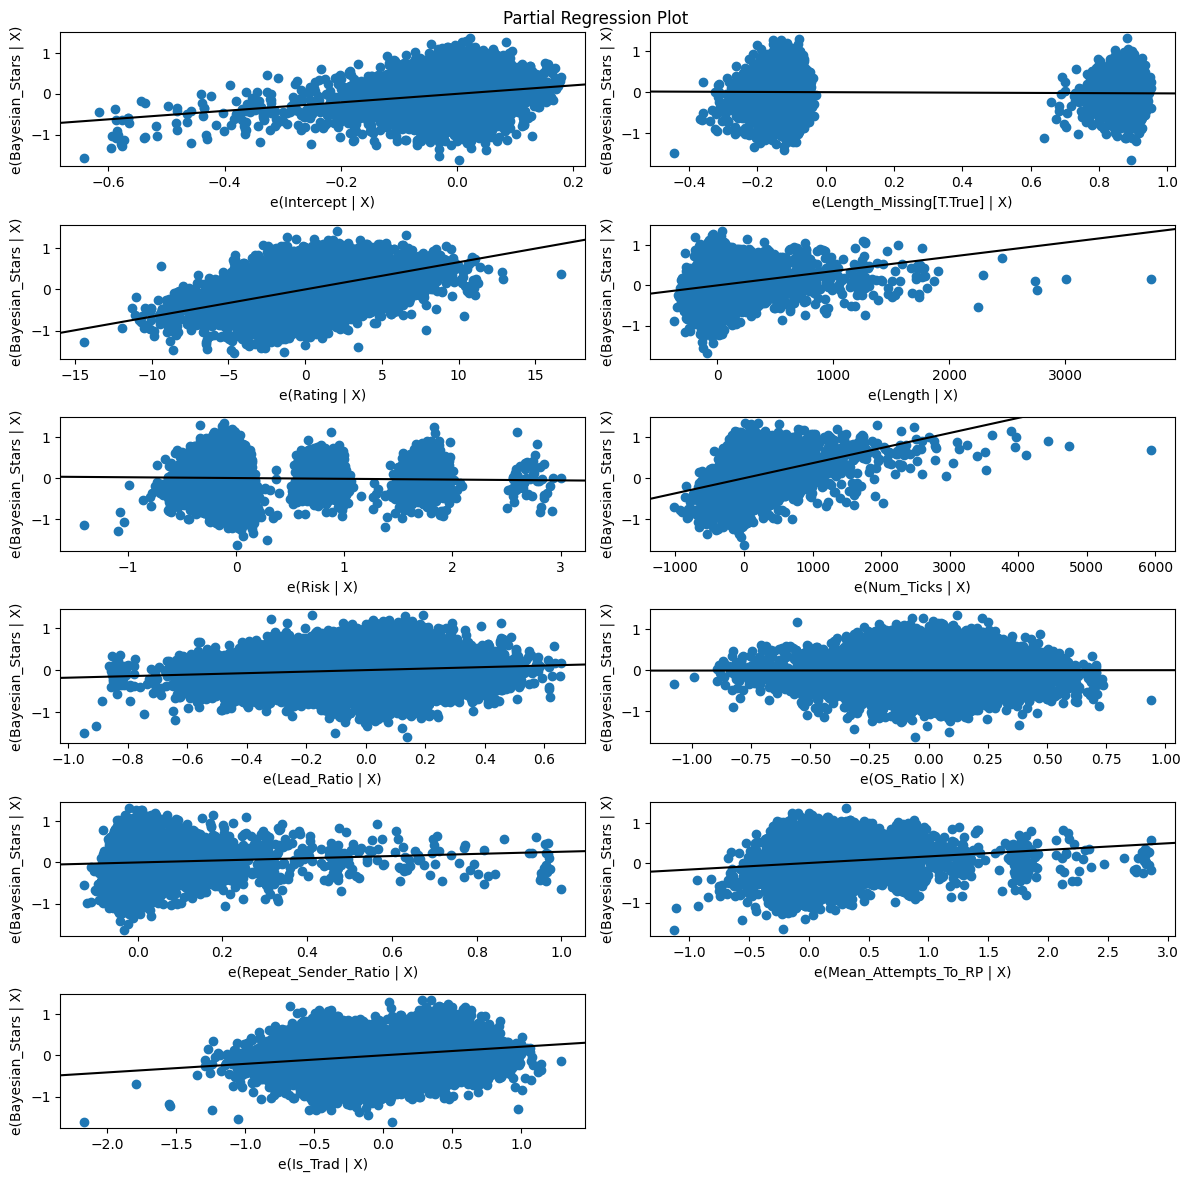

In [1203]:
fig = sm.graphics.plot_partregress_grid(lm)
fig.set_size_inches(12,12)
fig.tight_layout(pad=1.0)
fig